In [1]:
cd ..

/Users/jibanmac/Documents/GitHub/gpy_dla_detection


In [2]:
from matplotlib import pyplot as plt
import h5py
import os
import time
import numpy as np

# corner plot for the posterior distribution
import corner

from gpy_dla_detection.read_spec import read_spec, retrieve_raw_spec
from gpy_dla_detection.civ_set_parameter import CIVParameters as Parameters
from gpy_dla_detection.civ_gp import CIVGPMAT
from astropy.io import fits


# GP model for constraining CIV parameters using MCMC

Read your data

In [3]:
# download your raw data
from urllib import request

filename = "spSpec-51699-0349-542.fit"

if not os.path.exists(os.path.join("data/dr7q/", filename)):
    url = "http://das.sdss.org/spectro/1d_26/0349/1d/spSpec-51699-0349-542.fit"

    print("[Info] retrieving {} ...".format(url), end=" ")
    request.urlretrieve(url, filename)
    print("Done.")

    os.makedirs("data/dr7q/", exist_ok=True)
    os.replace(filename, os.path.join("data/dr7q/", filename))


In [4]:
plate: int = 349
mjd: int = 51699
fiber_id: int = 542
z_qso: float =  2.7348


# filename = "data/dr7q/spSpec-{}-{}-{}.fits".format(mjd, str(plate).zfill(4), str(fiber_id).zfill(3))

# if not os.path.exists(filename):
#     retrieve_raw_spec(plate, mjd, fiber_id)  # the spectrum at paper

# http://classic.sdss.org/dr7/dm/flatFiles/spSpec.html#spec
filename = "data/dr7q/spSpec-51699-0349-542.fit"

with fits.open(filename) as hdu:
    # Primary HDU image: spectrum, continuum-subtracted spectrum, noise in spectrum, mask array.
    data = hdu[0].data

    # coadded calibrated flux 10**-17 erg s**-1 cm**-2 A**-1
    flux = data[0, :]

    # noise variance
    noise_variance = data[2, :]**2

    # `and` mask
    and_mask = data[3, :]

    coeff0 = hdu[0].header["COEFF0"]
    coeff1 = hdu[0].header["COEFF1"]

    length = len(flux)

    # Λ = 10**(COEFF0 + COEFF1*i), where i denotes the (zero indexed) pixel number.
    wavelengths = 10**np.linspace(coeff0, coeff0 + coeff1*(length + 1), length)

    pixel_mask = (noise_variance == 0) | np.array(
        and_mask == int('0x800000', 16)
    ).astype("bool")



param = Parameters()

# wavelengths, flux, noise_variance, pixel_mask = read_spec(filename)

rest_wavelengths = param.emitted_wavelengths(wavelengths, z_qso)


In [5]:
# DLA GP Model
civ_gp = CIVGPMAT(
    param,
    3000.0,
    "data/dr7q/learned_model-C13_full.mat",
    True,
)
civ_gp.set_data(
    rest_wavelengths, flux, noise_variance, pixel_mask, z_qso, build_model=True
)

Text(0, 0.5, 'Normalized flux')

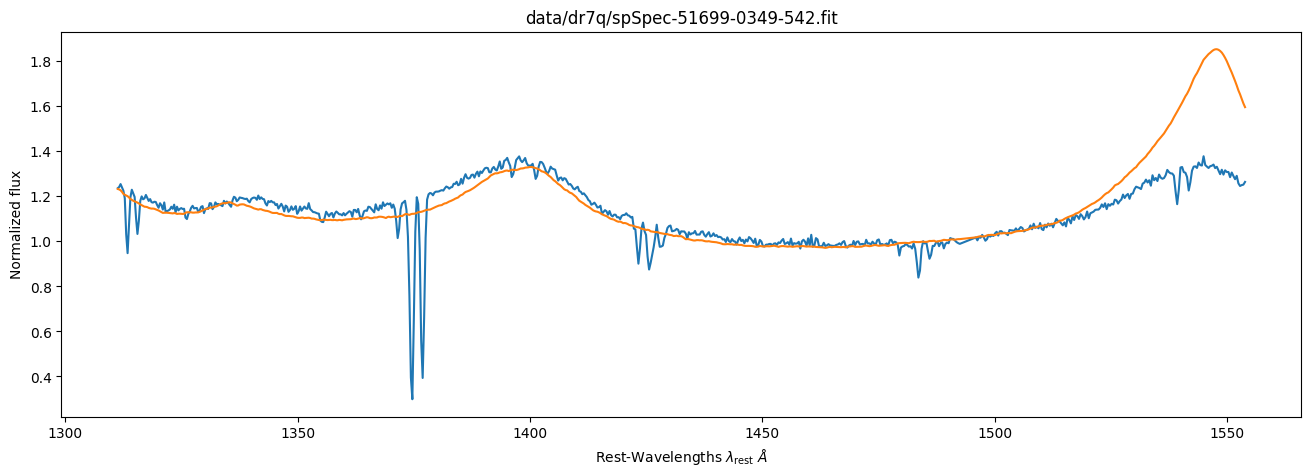

In [6]:
plt.figure(figsize=(16, 5))

plt.plot(civ_gp.x, civ_gp.y)
plt.plot(civ_gp.x, civ_gp.this_mu)

plt.title(filename)
plt.xlabel(r"Rest-Wavelengths $\lambda_{\mathrm{rest}}$ $\AA$")
plt.ylabel(r"Normalized flux")


## Initialize the MCMC sampler

In [7]:
nsamples = 10000

sampler = civ_gp.run_mcmc(nwalkers=40, kth_civ=1, nsamples=nsamples)

100%|██████████| 10000/10000 [02:42<00:00, 61.48it/s]


In [8]:
# get your MCMC samples
samples = sampler.get_chain()


Text(0.5, 0, 'set number')

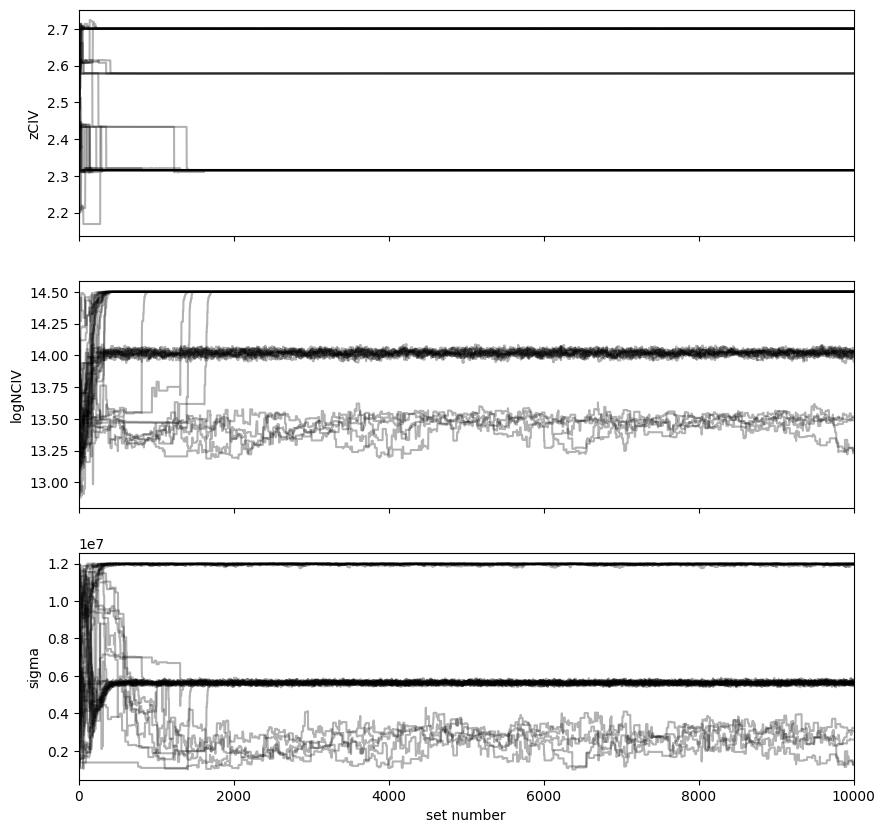

In [9]:
# Plot the chains to investigate if any weird thing happened
labels = ["zCIV", "logNCIV", "sigma"]

fig, axes = plt.subplots(3, figsize=(10, 10), sharex=True)
for i in range(len(labels)):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel("set number")


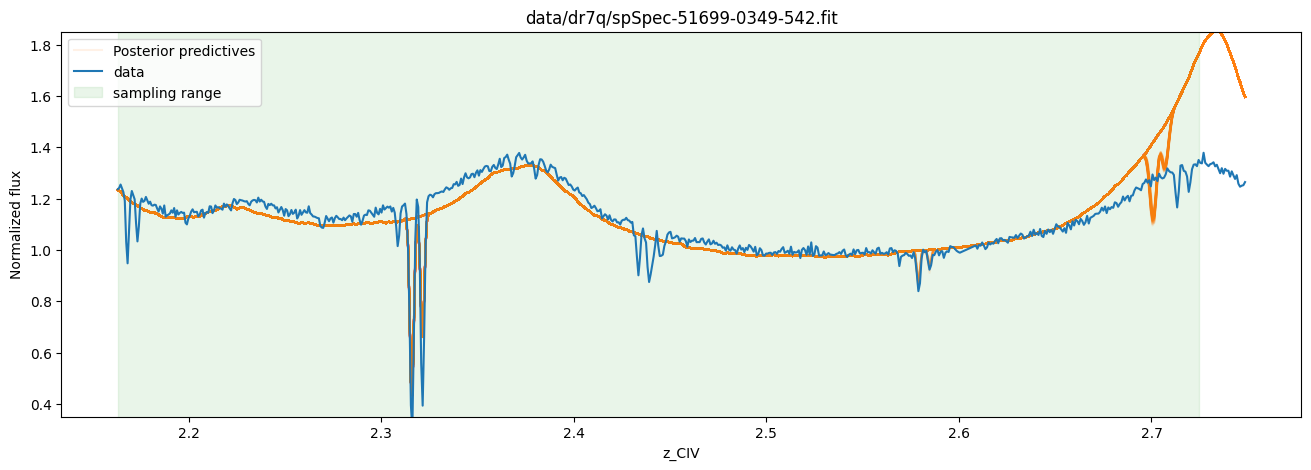

In [10]:
discard = 4000
# discard first 100; it is still multi-modal though
flat_samples = sampler.get_chain(discard=discard, thin=2, flat=True)

plt.figure(figsize=(16, 5))
plt.title(filename)

# Plot the posterior predictives
inds = np.random.randint(len(flat_samples), size=200)
for ind in inds:
    sample = flat_samples[ind]
    z_civ, log_civ, sigma = sample
    civ_mu, civ_M = civ_gp.this_civ_gp(
        np.array([z_civ]), np.array([10 ** log_civ]), np.array([sigma]),
    )

    plt.plot(civ_gp.x * (1 + civ_gp.z_qso) / civ_gp.params.civ_1548_wavelength - 1, civ_mu, color="C1", alpha=0.1)

# this line is just for plotting
plt.plot(civ_gp.x * (1 + civ_gp.z_qso) / civ_gp.params.civ_1548_wavelength - 1, civ_mu, color="C1", alpha=0.1, label="Posterior predictives")    

plt.plot(civ_gp.x  * (1 + civ_gp.z_qso) / civ_gp.params.civ_1548_wavelength - 1, civ_gp.y, color="C0", label="data")
plt.xlabel(r"z_CIV")
plt.ylabel(r"Normalized flux")

# plot the sampling range in zCIV
min_z_civ = civ_gp.params.min_z_civ(civ_gp.this_wavelengths, civ_gp.z_qso)
max_z_civ = civ_gp.params.max_z_civ(civ_gp.this_wavelengths, civ_gp.z_qso)

plt.fill_betweenx(np.linspace(0.2, 2.0), min_z_civ, max_z_civ, alpha=0.1, color="C2", label="sampling range")

plt.ylim(0.35, 1.85)
plt.legend()

Chains: [ 0  2  4  5  6  7 10 11 14 15 16 17 21 22 23 28 31 32 34 35 37 39]


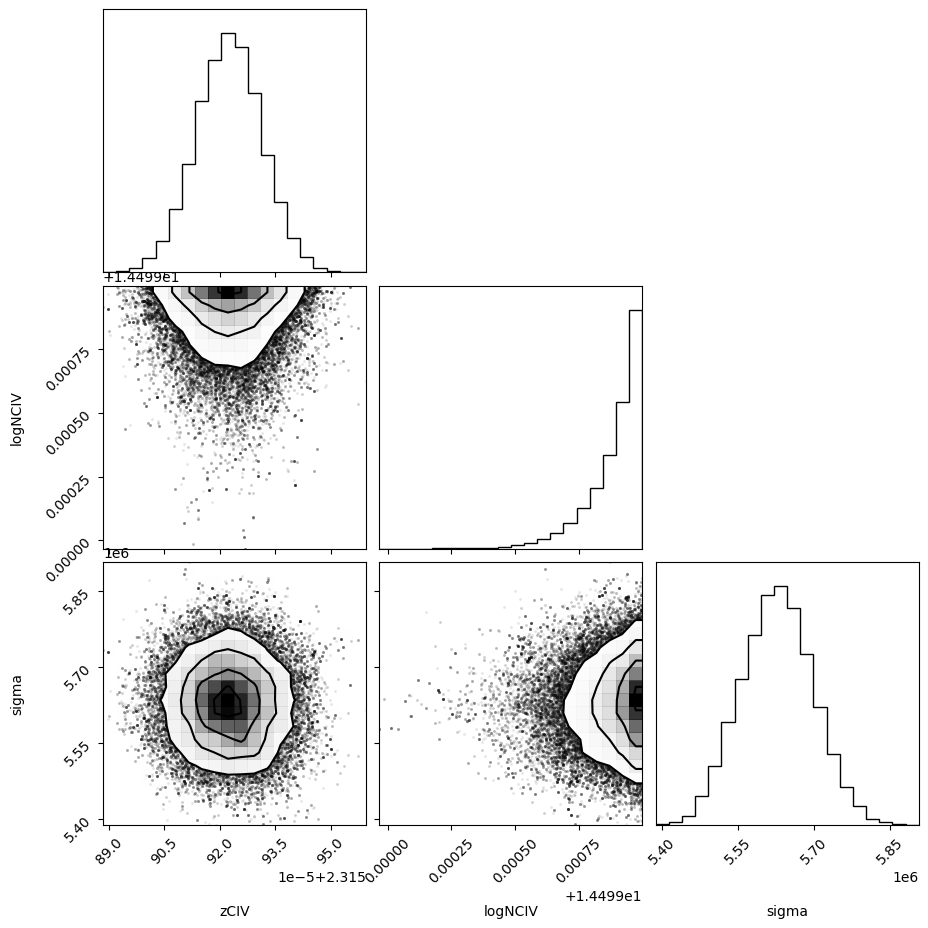

In [11]:
min_z = 2.3
max_z = 2.35
discard = 4000

# [min_z, max_z] only plot those samples within min_z~max_z range
selected_ind = np.where(
    (samples[:, :, :].mean(axis=0)[:, 0] > min_z) & 
    (samples[:, :, :].mean(axis=0)[:, 0] < max_z) )[0]
# flatten multiple chains to one chain
flat_samples = samples[discard:, selected_ind, :].reshape(
    (samples.shape[0] - discard) * len(selected_ind), samples.shape[-1]
)

try:
    # a corner plot
    fig = corner.corner(flat_samples, labels=labels,)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    print("Chains:", selected_ind)
except AssertionError as e:
    print(e)
    print("[Warning] Did not find this absorber. Try to increase the nwalkers")

Chains: [ 3  8 27 36 38]


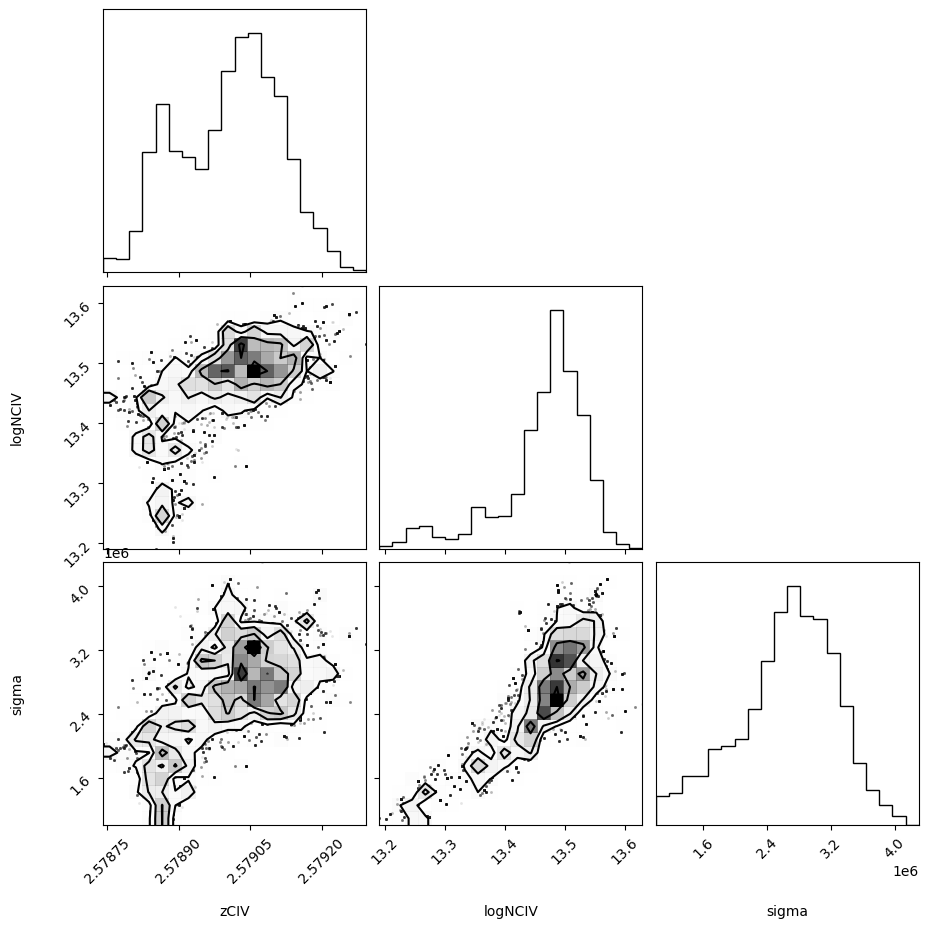

In [12]:
min_z = 2.55
max_z = 2.6
discard = 4000

# [min_z, max_z] only plot those samples within min_z~max_z range
selected_ind = np.where(
    (samples[:, :, :].mean(axis=0)[:, 0] > min_z) & 
    (samples[:, :, :].mean(axis=0)[:, 0] < max_z) )[0]
# flatten multiple chains to one chain
flat_samples = samples[discard:, selected_ind, :].reshape(
    (samples.shape[0] - discard) * len(selected_ind), samples.shape[-1]
)

try:
    # a corner plot
    fig = corner.corner(flat_samples, labels=labels,)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    print("Chains:", selected_ind)
except AssertionError as e:
    print(e)
    print("[Warning] Did not find this absorber. Try to increase the nwalkers")

In [13]:
min_z = 2.4
max_z = 2.5
discard = 4000

# [min_z, max_z] only plot those samples within min_z~max_z range
selected_ind = np.where(
    (samples[:, :, :].mean(axis=0)[:, 0] > min_z) & 
    (samples[:, :, :].mean(axis=0)[:, 0] < max_z) )[0]
# flatten multiple chains to one chain
flat_samples = samples[discard:, selected_ind, :].reshape(
    (samples.shape[0] - discard) * len(selected_ind), samples.shape[-1]
)

try:
    # a corner plot
    fig = corner.corner(flat_samples, labels=labels,)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    print("Chains:", selected_ind)
except AssertionError as e:
    print(e)
    print("[Warning] Did not find this absorber. Try to increase the nwalkers")

I don't believe that you want more dimensions than samples!
[Warning] Did not find this absorber. Try to increase the nwalkers


Chains: [ 1  9 12 13 18 19 20 24 25 26 29 30 33]


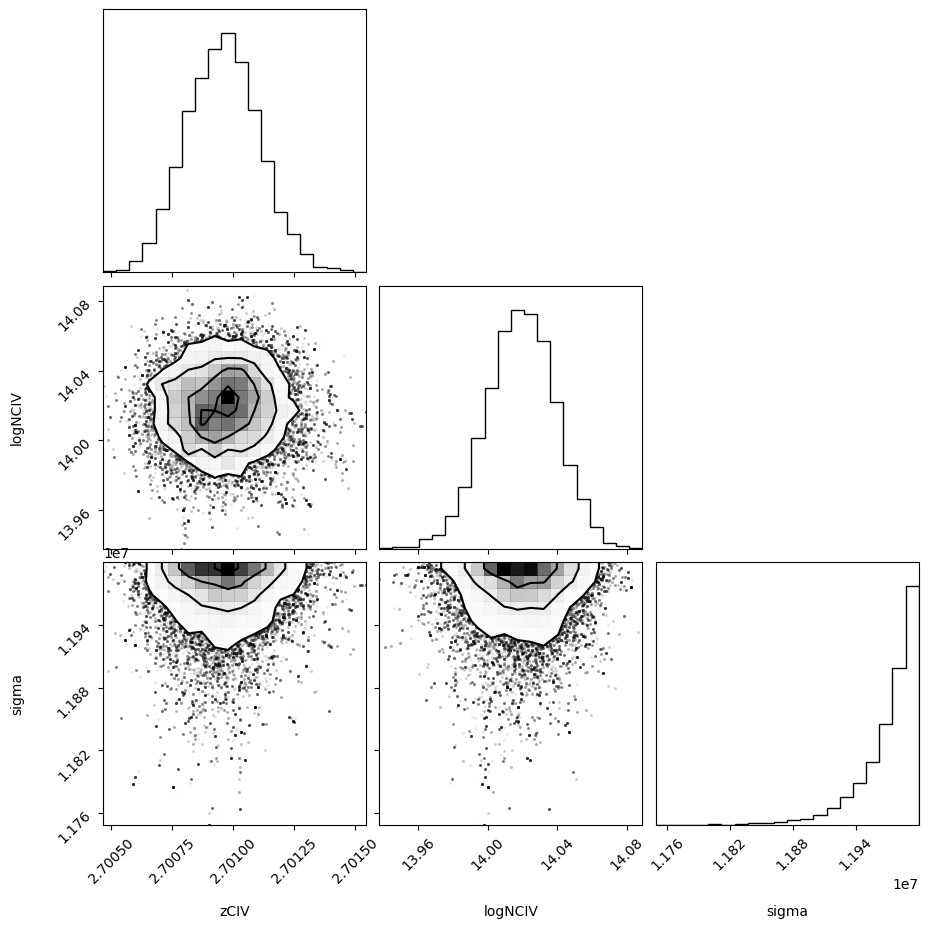

In [14]:
min_z = 2.69
max_z = 2.75
discard = 4000

# [min_z, max_z] only plot those samples within min_z~max_z range
selected_ind = np.where(
    (samples[:, :, :].mean(axis=0)[:, 0] > min_z) & 
    (samples[:, :, :].mean(axis=0)[:, 0] < max_z) )[0]
# flatten multiple chains to one chain
flat_samples = samples[discard:, selected_ind, :].reshape(
    (samples.shape[0] - discard) * len(selected_ind), samples.shape[-1]
)

try:
    # a corner plot
    fig = corner.corner(flat_samples, labels=labels,)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    print("Chains:", selected_ind)
except AssertionError as e:
    print(e)
    print("[Warning] Did not find this absorber. Try to increase the nwalkers")

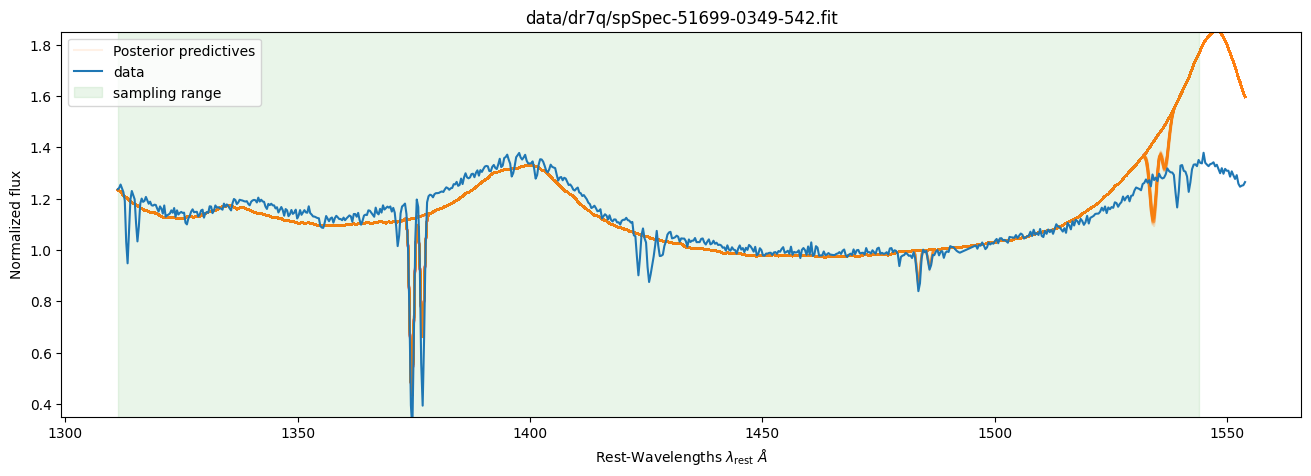

In [15]:
# discard first 100; it is still multi-modal though
flat_samples = sampler.get_chain(discard=discard, thin=2, flat=True)

plt.figure(figsize=(16, 5))
plt.title(filename)

# Plot the posterior predictives
inds = np.random.randint(len(flat_samples), size=200)
for ind in inds:
    sample = flat_samples[ind]
    z_civ, log_civ, sigma = sample
    civ_mu, civ_M = civ_gp.this_civ_gp(
        np.array([z_civ]), np.array([10 ** log_civ]), np.array([sigma]),
    )

    plt.plot(civ_gp.x, civ_mu, color="C1", alpha=0.1)

# this line is just for plotting
plt.plot(civ_gp.x, civ_mu, color="C1", alpha=0.1, label="Posterior predictives")    

plt.plot(civ_gp.x, civ_gp.y, color="C0", label="data")
plt.xlabel(r"Rest-Wavelengths $\lambda_{\mathrm{rest}}$ $\AA$")
plt.ylabel(r"Normalized flux")

# plot the sampling range in zCIV
min_z_civ = civ_gp.params.min_z_civ(civ_gp.this_wavelengths, civ_gp.z_qso)
max_z_civ = civ_gp.params.max_z_civ(civ_gp.this_wavelengths, civ_gp.z_qso)

min_rest_wavelength = (1 + min_z_civ) * civ_gp.params.civ_1548_wavelength / (1 + civ_gp.z_qso)
max_rest_wavelength = (1 + max_z_civ) * civ_gp.params.civ_1548_wavelength / (1 + civ_gp.z_qso)

plt.fill_betweenx(np.linspace(0.2, 2.0), min_rest_wavelength, max_rest_wavelength, alpha=0.1, color="C2", label="sampling range")

plt.ylim(0.35, 1.85)
plt.legend()